In [1]:
from scipy.io import loadmat
from itertools import product
import os

from processing import mis
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from tqdm.autonotebook import tqdm

#srcpath = os.path.realpath(__file__)
#workdir, _ = os.path.split(srcpath)

mis.configure_mpl()

/tmp/ipykernel_3052/1936627129.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# ------------------------- #

def thickness(edge = 15, gap = 166, radius = 20):
    return (edge - 1) * gap + 2 * radius

def E_int_opt(
    
        field, 
        idxs, 
        dphis, # arrs args
        dthetas, # arrs args
        coords,
        thickness = thickness(gap = 249),
        cylw = 400

    ):

    x = coords[:, 0]
    y = coords[:, 1]
    z = coords[:, 2]

    globnrm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    gl = np.where((globnrm >= 2 * thickness) & (globnrm <= (coords.max() * 1.02)))[0]

    x = x[gl]
    y = y[gl]
    z = z[gl]

    output = []

    for p in tqdm(dphis):

        row = []

        x1 = x * np.cos(np.pi * p / 180) - y * np.sin(np.pi * p / 180)
        y1 = x * np.sin(np.pi * p / 180) + y * np.cos(np.pi * p / 180)

        for t in dthetas:

            x2 = x1 * np.cos(np.pi * t / 180) + z * np.sin(np.pi * t / 180)
            y2 = y1
            z2 = z * np.cos(np.pi * t / 180) - x1 * np.sin(np.pi * t / 180)
            cylnrm = np.sqrt(x2 ** 2 + y2 ** 2)

            cylidx = np.where(cylnrm <= cylw)[0]
            cylzb0 = np.where(z2 >= 0)[0]

            stbl = list(set(cylidx).intersection(set(cylzb0)))
            stbl = gl[stbl]

            val = np.sum([field[idxs[i]] for i in stbl])
            row.append(val)
        
        output.append(row)
    
    return np.array(output).T # to plot as polar


# ------------------------- #

In [4]:
root = './matlab/output/cylinder'
fname = 'cylinder_15edge_249gap_50radius_0.0nonreg_1.8702m_15deg_TEpol_83wav_800bw.mat'

file = loadmat(os.path.join(root, fname))

In [5]:
field = np.transpose(file['eField3DAbs'], (1, 0, 2))
field = np.nan_to_num(field)

dim = field.shape[0]
grid_max = int(file['grid_max'][0][0])
coord = np.linspace(-grid_max, grid_max, dim)

idxs = list(product(range(dim), repeat=3))
coords = np.array(list(product(coord, repeat=3)))

In [10]:
dphis = np.linspace(0, 180, 60)
dthetas = np.linspace(90, 180, 90)

eintcalc = E_int_opt(dphis=dphis, dthetas=dthetas, coords=coords, field=field, idxs=idxs)


dphimesh, dthetamesh = np.meshgrid(np.append(dphis, dphis + 180) * np.pi / 180, dthetas) #rectangular plot of polar data

100%|██████████| 60/60 [05:49<00:00,  5.83s/it]


In [7]:
#plt.imshow(field[:, 11, :])

/tmp/ipykernel_3052/3827596610.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])


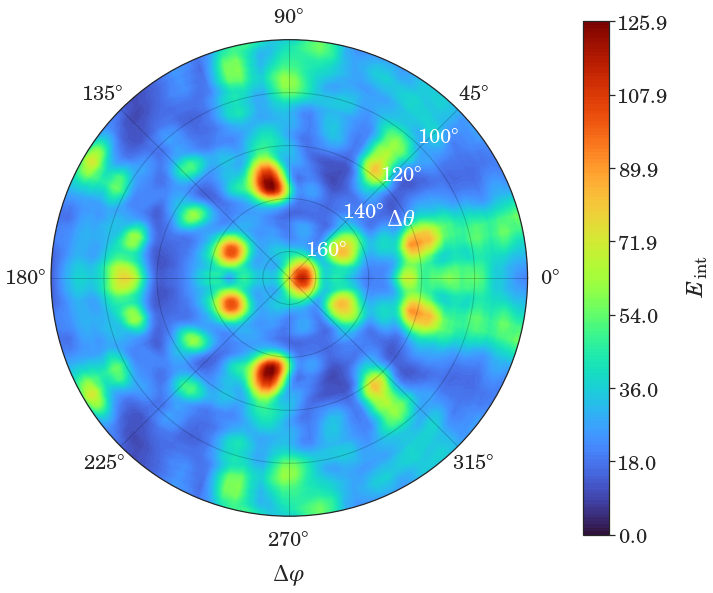

In [11]:
# plotting

# to reverse polar plot for theta from 180 to 90
dphimesh, dthetamesh = np.meshgrid(np.append(dphis, dphis + 180) * np.pi / 180, 270 - dthetas)
#####


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar='True')
ax.grid(True, alpha=0.2, color='black')
cax = ax.contourf(dphimesh, dthetamesh, np.concatenate([eintcalc, eintcalc[:, ::-1]], axis=1), cmap='turbo', levels=np.linspace(0, eintcalc.max(), 150), zorder=-1)
ax.set_xlabel(r'$\Delta \varphi$', labelpad=15)
ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])

ax.set_rgrids(range(100, 170, 20), angle=45)
#ax.set_rgrids(range(10, 80, 20), angle=45)
ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in list(range(100, 170, 20))[::-1]], color='white')
#ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(10, 80, 20)], color='white')

ax.xaxis.set_tick_params(pad=10)

cbar = plt.colorbar(cax, fraction=0.046, pad=0.1)
cbar.set_label(r'$E_{\rm{int}}$', labelpad=15)

cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(8))

rlab = ax.set_ylabel(r'$\Delta \theta$', color='white')
rlab.set_position((5, 0.6))
rlab.set_rotation(0)
ax.yaxis.labelpad = -350

for c in cax.collections:
    c.set_edgecolor("face")

In [12]:
#fig.savefig(f'../tex/components/img/celes/e_int_cylinder_15edge_theta0_15_phi0_0_249gap_rad50nm_refr.pdf', bbox_inches='tight')